In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import scanpy as sc
import anndata
import shap
import subprocess

# import tensorflow as tf

import mgitools.os_helpers as os_helpers

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from pollock.models.model import embed_from_anndata, predict_from_anndata, load_from_directory
from pollock.models.explain import explain_predictions

In [ ]:
modules_dir = '../benchmarking/results/10272020_teir1/'
module_fps = [fp for fp in os_helpers.listfiles(modules_dir, regex='pollock_module$')]
name_to_module = {'_'.join(fp.split('/')[-3:-1]):fp for fp in module_fps}
name_to_module = {k:v for k, v in name_to_module.items() if 'scRNA' in k}
name_to_module

#### visual

#### shap explain

In [ ]:
import shap

shap.initjs()

In [ ]:
module_fp = '../benchmarking/results/10272020_teir1/scRNAseq/pdac/pollock_module'

In [ ]:
adata_train = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac_train.h5ad')
adata_val = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac_val.h5ad')

X_train = pd.DataFrame(data=adata_train.X.toarray(),
                      index=adata_train.obs.index, columns=adata_train.var.index)
X_val = pd.DataFrame(data=adata_val.X.toarray(),
                      index=adata_val.obs.index, columns=adata_val.var.index)

In [ ]:
loaded_pds, loaded_pm = load_from_directory(adata_train, module_fp)

In [ ]:
def predict_probs_from_X(X):
    X = X if 'sparse' not in str(type(X)) else X.toarray()
    ds = tf.data.Dataset.from_tensor_slices(X).batch(256)
    return loaded_pm.predict(ds)

In [ ]:
def predict_probs_from_df(df):
    print(type(df))
    adata = anndata.AnnData(X=df.values)
    adata.obs.index = df.index
    adata.var.index = df.columns
    
    preds = predict_from_anndata(adata.copy(), module_fp)
    preds = preds[[c for c in preds.columns if 'probability_' in c]]
    return preds

In [ ]:
explainer = shap.KernelExplainer(predict_probs_from_X, shap.sample(adata_train.X, 20))
# shap_values = explainer.shap_values(X_val.iloc[0,:])

In [ ]:
shap_values = explainer.shap_values(adata_val.X[0, :])

In [ ]:
preds = predict_from_anndata(adata_val.copy(), module_fp)
preds

#### shap gradient explainer

###### testing

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import shap
import keras.backend as K
import json

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [ ]:
# import tensorflow.keras.backend as K

In [ ]:
??shap.GradientExplainer

In [ ]:
from tensorflow.compat.v1.keras.backend import get_session
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
module_fp = '../benchmarking/results/10272020_teir1/scRNAseq/pdac/pollock_module'
adata_train = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac_train.h5ad')
adata_val = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac_val.h5ad')
pds, pm = load_from_directory(adata_train, module_fp)

In [ ]:
# to_explain = adata_val.X[:2].toarray()
# to_explain.shape

In [ ]:
# pds.prediction_adata.shape

In [ ]:
pm.class_names

In [ ]:
from pollock.models.model import balancedish_training_generator
from collections import Counter
explain_adata, rest = balancedish_training_generator(pds.prediction_adata.copy(), 'cell_type', 10, oversample=False)
background, _ = balancedish_training_generator(rest.copy(), 'cell_type', 10, oversample=False)
Counter(explain_adata.obs['cell_type'])

In [ ]:
# background_adata = pds.prediction_adata[:100].copy()
# explain_adata =  pds.prediction_adata[100:].copy()


In [ ]:
n_layer = 0

In [ ]:
model = pm.model.layers[0]
def map2layer(x, layer):
#     feed_dict = {k:v for k, v in zip([model.layers[0].input], [x])}
    feed_dict = dict(zip([model.layers[0].input], [x]))
    return get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[n_layer].input, model.layers[-1].output),
    map2layer(background.X, n_layer))

In [ ]:
# mini = explain_adata[explain_adata.obs['cell_type']=='Malignant']
# mini

In [ ]:
shap_values = e.shap_values(map2layer(explain_adata.X, n_layer))

In [ ]:
len(shap_values), shap_values[0].shape

In [ ]:
np.asarray(shap_values[:pm.latent_dim]).res

In [ ]:
np.swapaxes(np.asarray(shap_values[:pm.latent_dim]), 0, 1).shape

In [ ]:
totals = np.asarray([np.sum(x, axis=0) for x in shap_values])
totals.shape

In [ ]:
ordering = np.argsort(totals, axis=1)
ordering

In [ ]:
f = lambda x: pds.prediction_adata.var.index[x]
xs = f(ordering)
xs

In [ ]:
np.save('../benchmarking/sandbox/shap_vals.npy', xs)

###### implementation

In [ ]:
import uuid

In [ ]:
module_fp = '../benchmarking/results/10272020_teir1/scRNAseq/pdac/pollock_module'
adata_train = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac_train.h5ad')
adata_val = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac_val.h5ad')

In [ ]:
from pollock.models.model import balancedish_training_generator
from collections import Counter
explain_adata, rest = balancedish_training_generator(adata_val.copy(), 'cell_type', 10, oversample=False)
background_adata, _ = balancedish_training_generator(rest.copy(), 'cell_type', 10, oversample=False)
Counter(explain_adata.obs['cell_type'])

In [ ]:
a, b, c = str(uuid.uuid4()), str(uuid.uuid4()), str(uuid.uuid4())
explain_adata_fp = f'../benchmarking/sandbox/{a}.h5ad'
background_adata_fp = f'../benchmarking/sandbox/{b}.h5ad'
output_fp = f'../benchmarking/sandbox/{c}.npy'

In [ ]:
explain_adata.write_h5ad(explain_adata_fp)
background_adata.write_h5ad(background_adata_fp)

In [ ]:
ENCODER_SHAPS_SCRIPT = '../pollock/wrappers/encoder_shaps.py'

In [ ]:
subprocess.check_output(('python', ENCODER_SHAPS_SCRIPT, explain_adata_fp, background_adata_fp,
                        module_fp, output_fp))

In [ ]:
embedding_shaps = np.load(output_fp)
embedding_shaps.shape

In [ ]:
# clean up
os.remove(explain_adata_fp)
os.remove(background_adata_fp)
os.remove(output_fp)

In [ ]:
embeddings = embed_from_anndata(explain_adata.copy(), module_fp)
embeddings

In [ ]:
_, pm = load_from_directory(explain_adata.copy(), module_fp)

In [ ]:
explainer = shap.TreeExplainer(pm.clf)
clf_shaps = explainer.shap_values(embeddings)

In [ ]:
clf_shaps = np.swapaxes(np.asarray(clf_shaps), 0, 1)
clf_shaps.shape

In [ ]:
# combine them together

In [ ]:
np.where(np.asarray([1,2,3,4,3,2,1])==2)[0][0]

In [ ]:
list(pm.class_names).index(explain_adata.obs['cell_type'][c])

In [ ]:
# (n_cells, n_embeddings, n_features)
# (n_cells, n_cell_types, n_embeddings)

totals = None
for i in range(explain_adata.shape[0]):
    cell_emb_shaps = clf_shaps[i, list(pm.class_names).index(explain_adata.obs['cell_type'][i]), :].flatten()
    # expected shape is (n_embeddings,)
    combined = cell_emb_shaps.reshape(-1, 1) * embedding_shaps[i]
    # expected shape is (n_embeddings, n_features)
    total = np.sum(combined, axis=0).flatten()
    # expected shape is (n_features,)
    if totals is None:
        totals = total.reshape(1, len(total))
    else:
        totals = np.concatenate((totals, total.reshape(1, len(total))), axis=0)
totals.shape

In [ ]:
df = pd.DataFrame(data=totals, index=explain_adata.obs.index, columns=explain_adata.var.index)
df

In [ ]:
shap.force_plot(explainer.expected_value[10], clf_shaps[0, 10].flatten(), embeddings.iloc[0,:])

In [ ]:
shap.force_plot(explainer.expected_value[10], clf_shaps[0, 10].flatten(), embeddings.iloc[-10,:])

In [ ]:
x = embedding_shaps[c] * cell_output_shaps.reshape(-1, 1)
x

In [ ]:
import seaborn as sns
sns.distplot(totals)

In [ ]:
t1 = totals.copy()

In [ ]:
explain_adata.var.index[np.argsort(totals)]

###### pollock calls

In [5]:
module_fp = '../benchmarking/results/10272020_teir1/scRNAseq/pdac/pollock_module'
adata_train = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac_train.h5ad')
adata_val = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac_val.h5ad')

In [6]:
from pollock.models.model import balancedish_training_generator
from collections import Counter
explain_adata, background_adata = balancedish_training_generator(adata_val.copy(), 'cell_type', 10, oversample=False)
Counter(explain_adata.obs['cell_type'])

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Counter({'Monocyte': 10,
         'Endothelial': 10,
         'Tuft': 10,
         'Epithelial': 10,
         'Islet': 10,
         'Fibroblast': 10,
         'Erythrocyte': 10,
         'Treg': 10,
         'Malignant': 10,
         'CD4 T cell': 10,
         'Mast': 10,
         'Dendritic': 10,
         'NK': 10,
         'Plasma': 10,
         'Acinar': 10,
         'B cell': 10,
         'CD8 T cell': 10})

In [8]:
os.path.abspath(module_fp)

'/home/estorrs/pollock/benchmarking/results/10272020_teir1/scRNAseq/pdac/pollock_module'

In [10]:
os.path.isabs(module_fp), os.path.isabs(os.path.abspath(module_fp))

(False, True)

In [12]:
df = explain_predictions(explain_adata, background_adata, module_fp, prediction_key='cell_type')
df

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-09 12:53:01,526 normalizing counts for prediction
2020-11-09 12:53:01,527 filtering for genes in training set
2020-11-09 12:53:01,537 0 genes in training set are missing from prediction set
2020-11-09 12:53:02,848 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-09 12:53:03,105 normalizing counts for prediction
2020-11-09 12:53:03,106 filtering for genes in training set
2020-11-09 12:53:03,116 0 genes in training set are missing from prediction set
2020-11-09 12:53:03,792 normalizing counts for prediction
2020-11-09 12:53:03,793 filtering for genes in training set
2020-11-09 12:53:03,805 0 genes in training set are missing from prediction set


,OR4F5,AL627309.1,AL627309.3,AL627309.4,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,...,AL592183.1,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1
HT056P_S1PA_AAACGAATCAAAGACA-1,0.0,0.0,0.0,0.0,0.0,0.000077,0.0,0.000013,0.0,0.0,...,0.000007,0.0,0.000019,0.0,0.000129,0.0,0.000035,0.0,0.0,0.000004
HT056P_S1PA_AGGTTGTTCCGTTGAA-1,0.0,0.0,0.0,0.0,0.0,0.000026,0.0,0.000007,0.0,0.0,...,0.000017,0.0,0.000000,0.0,0.000084,0.0,-0.000004,0.0,0.0,0.000011
HT056P_S1PA_ATCGTCCTCTGAACGT-1,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.000003,0.0,0.0,...,0.000008,0.0,0.000002,0.0,0.000036,0.0,-0.000004,0.0,0.0,0.000004
HT056P_S1PA_GGGTTATCATCGATCA-1,0.0,0.0,0.0,0.0,0.0,0.000028,0.0,0.000000,0.0,0.0,...,0.000020,0.0,0.000016,0.0,0.000094,0.0,0.000024,0.0,0.0,-0.000015
HT056P_S1PA_TACGCTCGTATGGGAC-1,0.0,0.0,0.0,0.0,0.0,0.000024,0.0,0.000008,0.0,0.0,...,0.000020,0.0,0.000054,0.0,0.000061,0.0,0.000035,0.0,0.0,-0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT168P1_S1H3_TCAATTCCAACGGCCT-1,0.0,0.0,0.0,0.0,0.0,0.000020,0.0,0.000016,0.0,0.0,...,-0.001868,0.0,0.000000,0.0,0.000328,0.0,0.000007,0.0,0.0,0.000015
HT168P1_S1H3_TCGACGGTCATGCATG-1,0.0,0.0,0.0,0.0,0.0,0.000030,0.0,0.000011,0.0,0.0,...,0.000043,0.0,0.000037,0.0,0.000175,0.0,-0.000202,0.0,0.0,-0.000009
HT168P1_S1H3_TGCATCCAGACCACGA-1,0.0,0.0,0.0,0.0,0.0,0.000034,0.0,0.000010,0.0,0.0,...,0.000007,0.0,0.000000,0.0,0.000073,0.0,-0.000007,0.0,0.0,0.000010
HT168P1_S1H4_CTCCACAAGGTAATCA-1,0.0,0.0,0.0,0.0,0.0,0.000015,0.0,0.000007,0.0,0.0,...,0.000041,0.0,0.000004,0.0,0.000127,0.0,0.000000,0.0,0.0,0.000007


In [17]:
order = explain_adata.obs.sort_values('cell_type').index
order

Index(['HT071P_S1H5_TTACAGGTCACCTCAC-1', 'HT168P1_S1H3_TGCATCCAGACCACGA-1',
       'HT168P1_M1_AACAAGAGTTGTCATG-1', 'HT122P1_S1H3_ATCGTAGAGGAGCAAA-1',
       'HT168P1_M1_GGAACCCCAGGTTCGC-1', 'HT122P1_S1H3_CCCATTGGTGGCTGCT-1',
       'HT122P1_S1H3_TCATGAGCATTACGGT-1', 'HT168P1_M1_TCAGTTTTCAATCTTC-1',
       'HT168P1_M1_TGTTGAGCACCGCTGA-1', 'HT168P1_S1H2_GGGTGAAAGAGGGTGG-1',
       ...
       'HT056P_S1R1_CTGTATTGTTATCTTC-1', 'HT056P_S1R1_CCTAAGACAAGCTGTT-1',
       'HT056P_S1R1_AGGTTACCAAATTGCC-1', 'HT056P_S1PB_GTCCACTAGCAACAGC-1',
       'HT056P_S1PB_CAGGCCATCACGGGAA-1', 'HT056P_S1PA_TTTGGTTGTGCCGGTT-1',
       'HT056P_S1PA_TCACTATAGACCTTTG-1', 'HT056P_S1PA_TACGCTCGTATGGGAC-1',
       'HT056P_S1PA_GGGTTATCATCGATCA-1', 'HT056P_S1PA_ATCGTCCTCTGAACGT-1'],
      dtype='object', length=170)

In [29]:
malignant = ['cell_type', 'EPCAM', 'KRT18']
combined = pd.merge(df, explain_adata.obs, left_index=True, right_index=True)
t = combined.loc[order][malignant]
t[t['cell_type']=='Malignant']

,cell_type,EPCAM,KRT18
HT061P_S1PC_ATCCATTCACATAACC-1,Malignant,0.001236,0.000232
HT061P_S1PC_AGAGAGCAGGGCTTCC-1,Malignant,0.000985,0.000674
HT122P1_S1H4_CATGCAAGTTCATCTT-1,Malignant,-0.001019,-0.000103
HT168P1_S1H3_GTATTGGAGTTCTCTT-1,Malignant,-0.000019,0.000020
HT122P1_S1H9_GATGATCTCTCGCCTA-1,Malignant,0.000017,0.000023
HT166P1_S1H6_TATTGGGGTGCCGGTT-1,Malignant,-0.000032,-0.000004
HT060P_S1PA_TCAATCTCACAAGCCC-1,Malignant,0.000402,0.000966
HT140P1_S1H3_TCCGATCCATCGCTAA-1,Malignant,0.001589,0.000069
HT140P1_S1H3_GACATCAGTTCTCCTG-1,Malignant,-0.000080,-0.000005
HT166P1_S1H2_ACAAAGAAGCTATCTG-1,Malignant,-0.000077,-0.000110


In [72]:
np.count_nonzero(adata_train.var['sct.variable']==1)

3000

In [73]:
feature_adata = anndata.AnnData(X=np.abs(df.values))
feature_adata.obs = explain_adata.obs.loc[df.index]
feature_adata.var.index = df.columns
# filter for only highly variable
feature_adata = feature_adata[:, adata_train.var['sct.variable']==1]
feature_adata

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 170 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'ident'

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


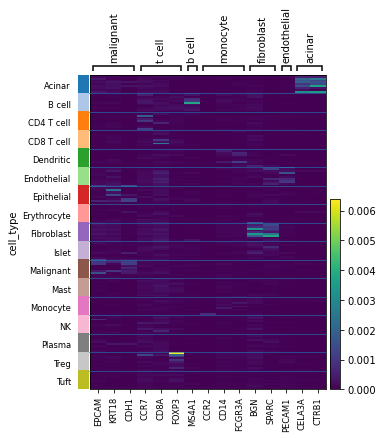

In [87]:
markers = {
    'malignant': ['EPCAM', 'KRT18', 'CDH1'],
    't cell': ['CCR7', 'CD8A', 'FOXP3'],
    'b cell': ['MS4A1'],
    'monocyte': ['CCR2', 'CD14', 'FCGR3A'],
    'fibroblast': ['BGN', 'SPARC'],
    'endothelial': ['PECAM1'],
    'acinar': ['CELA3A', 'CTRB1']
}
sc.pl.heatmap(feature_adata, var_names=markers, groupby='cell_type')

In [82]:
adata = feature_adata.copy()
# sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.scale(adata)
sc.pp.neighbors(adata)
sc.pp.pca(adata)

sc.tl.umap(adata)
sc.tl.leiden(adata)
adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 170 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'ident', 'leiden'
    var: 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

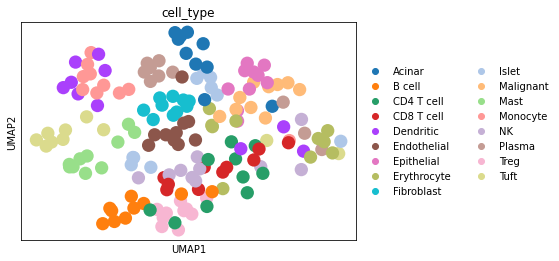

In [83]:
sc.pl.umap(adata, color='cell_type')

invalid value encountered in log2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


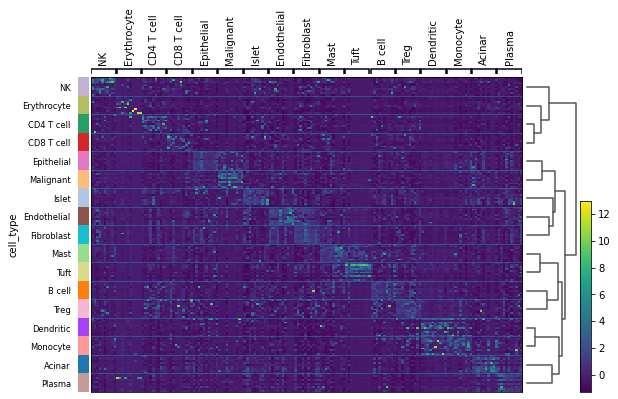

In [84]:
sc.tl.rank_genes_groups(adata, groupby='cell_type')
sc.pl.rank_genes_groups_heatmap(adata)

categories: Acinar, B cell, CD4 T cell, etc.
var_group_labels: Malignant, Acinar


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


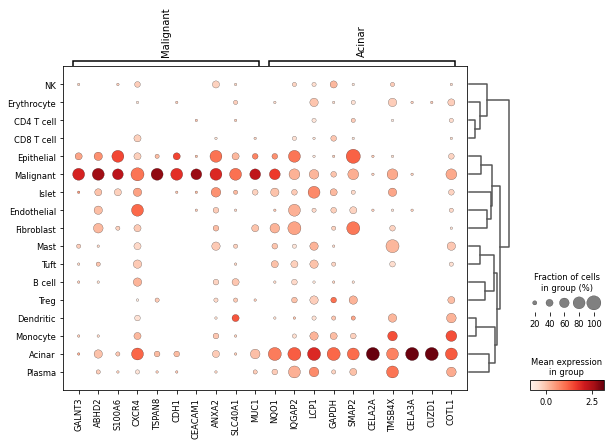

In [86]:
sc.pl.rank_genes_groups_dotplot(adata, groups=['Malignant', 'Acinar'])

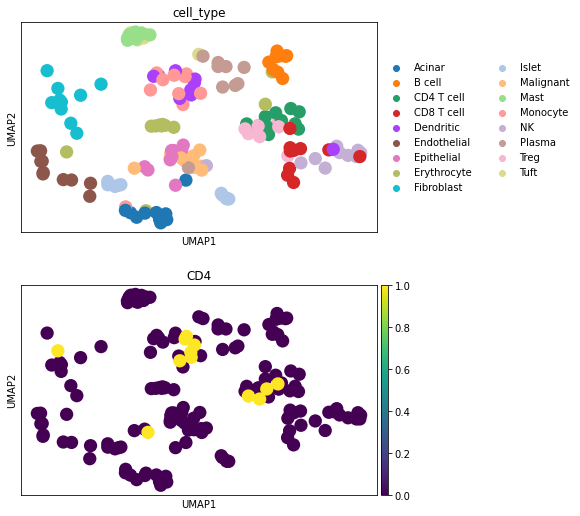

In [68]:
sc.pl.umap(explain_adata, color=['cell_type', 'CD4'], ncols=1)

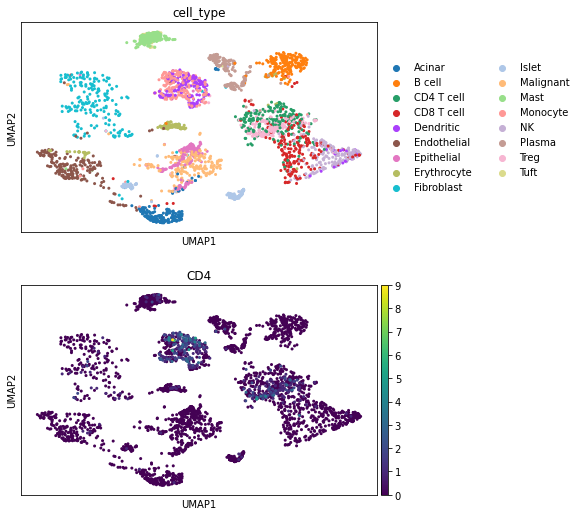

In [66]:
sc.pl.umap(adata_train, color=['cell_type', 'CD4'], ncols=1)

In [98]:
# take a gander at a bunch of maligant cells
malignant = adata_val[adata_val.obs['cell_type']=='Malignant']
malignant

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 1000 × 28756
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'ident'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [99]:
malig_df = explain_predictions(malignant, background_adata, module_fp, prediction_key='cell_type')
malig_df

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-09 17:36:26,883 normalizing counts for prediction
2020-11-09 17:36:26,885 filtering for genes in training set
2020-11-09 17:36:26,894 0 genes in training set are missing from prediction set
2020-11-09 17:36:27,550 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-09 17:36:27,890 normalizing counts for prediction
2020-11-09 17:36:27,891 filtering for genes in training set
2020-11-09 17:36:27,899 0 genes in training set are missing from prediction set
2020-11-09 17:36:30,830 normalizing counts for prediction
2020-11-09 17:36:30,831 filtering for genes in training set
2020-11-09 17:36:30,841 0 genes in training set are missing from prediction set


,OR4F5,AL627309.1,AL627309.3,AL627309.4,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,...,AL592183.1,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1
HT056P_S1PA_AACACACTCGCTTTAT-1,0.0,0.0,0.0,0.0,0.0,9.155398e-06,0.0,0.000016,1.946841e-06,0.0,...,0.000013,0.0,0.000000,0.0,0.000005,0.0,8.906452e-06,0.0,0.0,7.272210e-06
HT056P_S1PA_ACCACAAGTGTTAACC-1,0.0,0.0,0.0,0.0,0.0,3.072365e-06,0.0,0.000016,2.218390e-06,0.0,...,0.000046,0.0,0.000000,0.0,0.000008,0.0,9.438467e-07,0.0,0.0,4.280099e-07
HT056P_S1PA_ACCTACCTCGTTGTTT-1,0.0,0.0,0.0,0.0,0.0,1.312377e-05,0.0,0.000003,9.963343e-07,0.0,...,0.000037,0.0,0.000000,0.0,0.000014,0.0,2.721142e-05,0.0,0.0,0.000000e+00
HT056P_S1PA_AGGGTCCAGGTTGCCC-1,0.0,0.0,0.0,0.0,0.0,1.960080e-06,0.0,0.000000,1.614372e-06,0.0,...,0.000036,0.0,0.000582,0.0,0.000019,0.0,8.215234e-06,0.0,0.0,2.661010e-06
HT056P_S1PA_AGTAGCTTCGGCATAT-1,0.0,0.0,0.0,0.0,0.0,1.219951e-05,0.0,0.000000,3.419298e-06,0.0,...,0.000036,0.0,0.000000,0.0,0.000007,0.0,2.014744e-05,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT168P1_S1H4_CTATAGGAGTGATAAC-1,0.0,0.0,0.0,0.0,0.0,5.785955e-06,0.0,0.000033,4.394495e-06,0.0,...,0.000069,0.0,0.000000,0.0,0.000000,0.0,4.312343e-06,0.0,0.0,0.000000e+00
HT168P1_S1H4_CTGTGAAAGGCTCAAG-1,0.0,0.0,0.0,0.0,0.0,5.005340e-07,0.0,0.000017,7.163311e-06,0.0,...,0.000072,0.0,0.000000,0.0,0.000017,0.0,5.328280e-05,0.0,0.0,2.272473e-05
HT168P1_S1H4_CTTCAATAGGCCACTC-1,0.0,0.0,0.0,0.0,0.0,4.865536e-06,0.0,0.000017,1.665634e-05,0.0,...,0.000025,0.0,0.000000,0.0,0.000058,0.0,5.378244e-05,0.0,0.0,6.641077e-06
HT168P1_S1H4_GATGCTAGTCAAGTTC-1,0.0,0.0,0.0,0.0,0.0,6.702997e-06,0.0,0.000033,5.914186e-06,0.0,...,0.000039,0.0,0.000000,0.0,0.000012,0.0,5.042250e-05,0.0,0.0,1.130562e-05


In [100]:
feature_adata = anndata.AnnData(X=malig_df.values)
feature_adata.obs = malignant.obs.loc[malig_df.index]
feature_adata.var.index = malig_df.columns
# filter for only highly variable
feature_adata = feature_adata[:, adata_train.var['sct.variable']==1]
feature_adata

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 1000 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'ident'

In [104]:
adata = feature_adata.copy()
# sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.scale(adata)
sc.pp.neighbors(adata)
sc.pp.pca(adata)

sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=.5)
adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 1000 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'ident', 'leiden'
    var: 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [109]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,cell_type,sample,treatment,tissue,ident,leiden
HT056P_S1PA_AACACACTCGCTTTAT-1,TWCE-HT056P-S1PAA1-lib1,3218.0,1239,0.065879,4418.0,1240,2,2,Malignant,HT056P,FOLFIRINOX,Tumor,Tumor,0
HT056P_S1PA_ACCACAAGTGTTAACC-1,TWCE-HT056P-S1PAA1-lib1,25868.0,4737,0.048516,6062.0,1833,23,23,Malignant,HT056P,FOLFIRINOX,Tumor,Tumor,0
HT056P_S1PA_ACCTACCTCGTTGTTT-1,TWCE-HT056P-S1PAA1-lib1,15516.0,4773,0.039185,5513.0,2408,3,3,Malignant,HT056P,FOLFIRINOX,Tumor,Tumor,0
HT056P_S1PA_AGGGTCCAGGTTGCCC-1,TWCE-HT056P-S1PAA1-lib1,31225.0,5356,0.087430,6024.0,1820,23,23,Malignant,HT056P,FOLFIRINOX,Tumor,Tumor,0
HT056P_S1PA_AGTAGCTTCGGCATAT-1,TWCE-HT056P-S1PAA1-lib1,59878.0,6947,0.093507,6268.0,1890,23,23,Malignant,HT056P,FOLFIRINOX,Tumor,Tumor,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT168P1_S1H4_CTATAGGAGTGATAAC-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,1148.0,752,0.047038,3570.0,922,14,14,Malignant,HT168P1,FOLFIRINOX,Tumor,Tumor,0
HT168P1_S1H4_CTGTGAAAGGCTCAAG-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,2726.0,1497,0.051724,4336.0,1500,14,14,Malignant,HT168P1,FOLFIRINOX,Tumor,Tumor,3
HT168P1_S1H4_CTTCAATAGGCCACTC-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,6045.0,2329,0.043838,5592.0,2329,3,3,Malignant,HT168P1,FOLFIRINOX,Tumor,Tumor,3
HT168P1_S1H4_GATGCTAGTCAAGTTC-1,TWCE-HT168P1-BC4-HT168P1-BC4_1,1593.0,854,0.030760,3856.0,947,3,3,Malignant,HT168P1,FOLFIRINOX,Tumor,Tumor,3


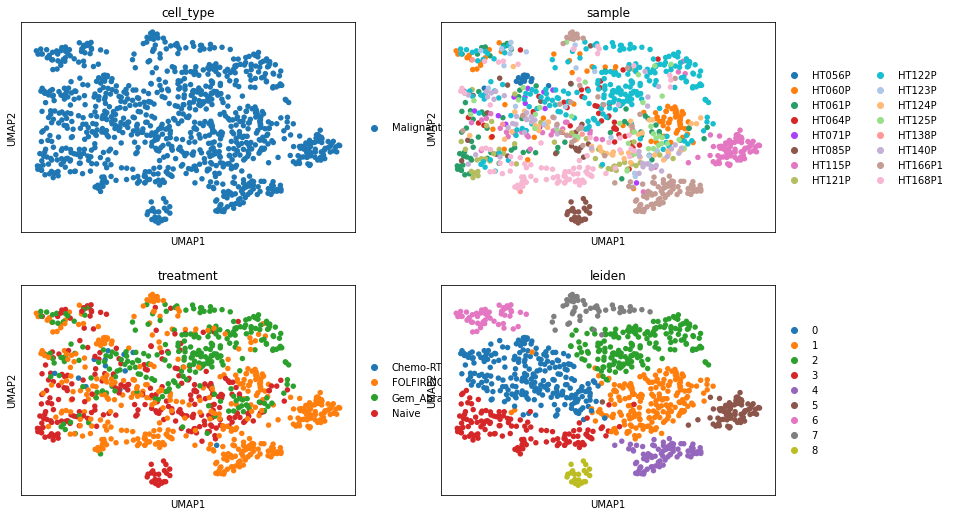

In [111]:
sc.pl.umap(adata, color=['cell_type', 'sample', 'treatment', 'leiden'], ncols=2)

invalid value encountered in log2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


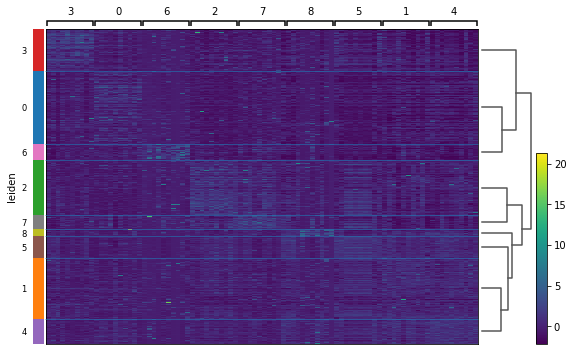

In [106]:
sc.tl.rank_genes_groups(adata, groupby='leiden')
sc.pl.rank_genes_groups_heatmap(adata)

categories: 0, 1, 2, etc.
var_group_labels: 6


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


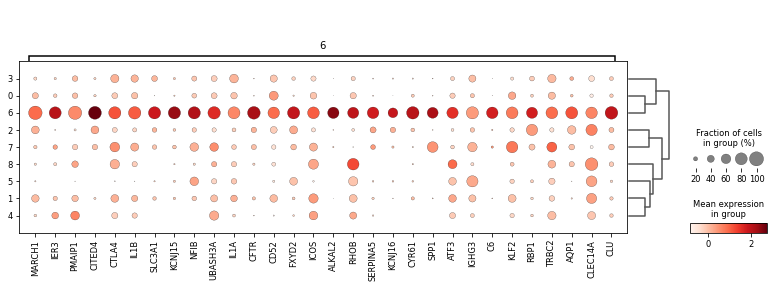

In [115]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=30, groups=['6'])

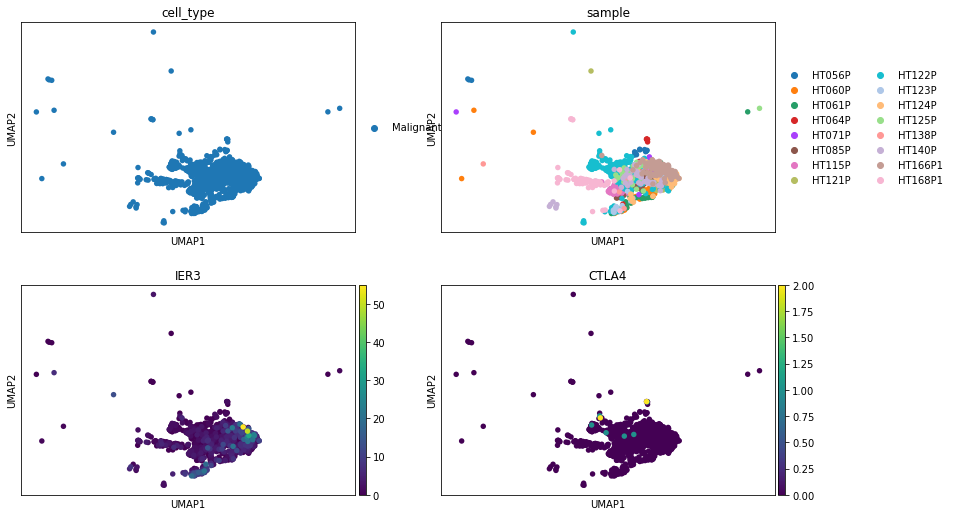

In [120]:
sc.pl.umap(malignant, color=['cell_type', 'sample', 'IER3', 'CTLA4'], ncols=2)

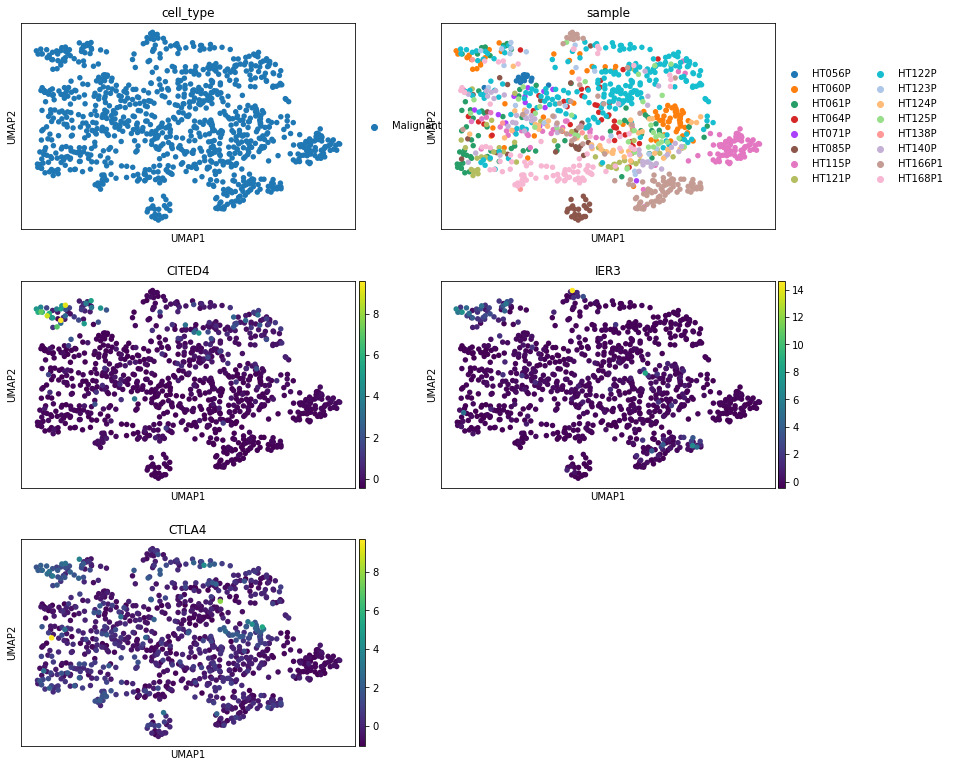

In [124]:
sc.pl.umap(adata, color=['cell_type', 'sample', 'CITED4', 'IER3', 'CTLA4'], ncols=2)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


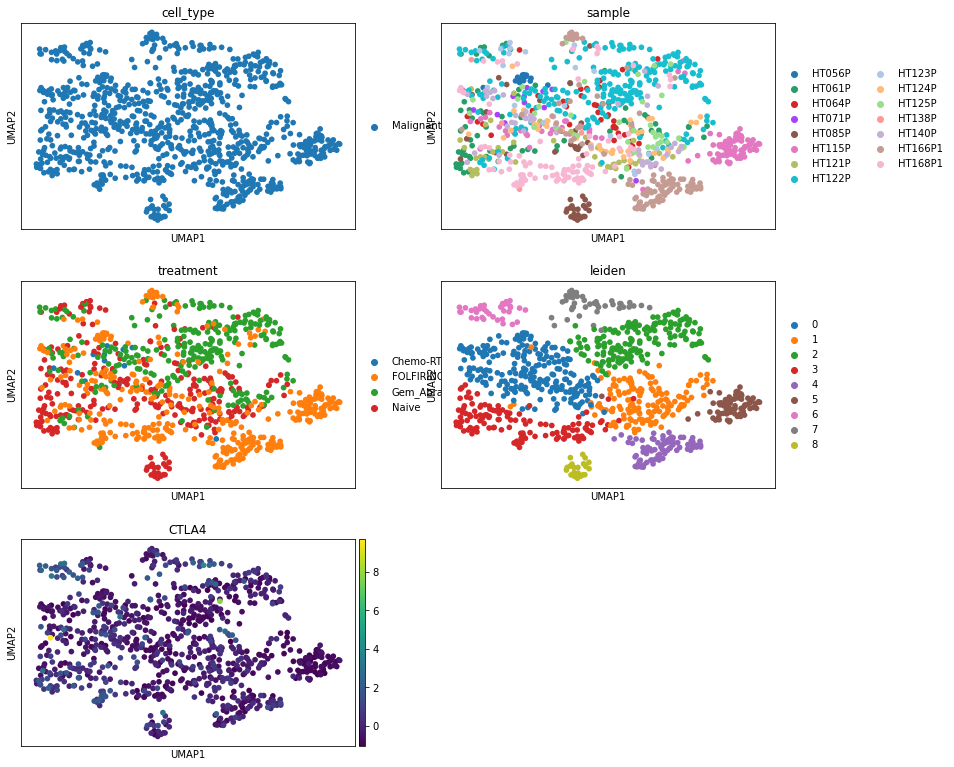

In [119]:
sc.pl.umap(adata[adata.obs['sample']!='HT060P'], color=['cell_type', 'sample', 'treatment', 'leiden', 'CTLA4'], ncols=2)

In [49]:
adata.var_names

Index(['OR4F5', 'AL627309.1', 'AL627309.3', 'AL627309.4', 'AL669831.2',
       'AL669831.5', 'FAM87B', 'LINC00115', 'FAM41C', 'AL645608.7',
       ...
       'AL592183.1', 'AC007325.1', 'AC007325.4', 'AC007325.2', 'AL354822.1',
       'AC023491.2', 'AC004556.1', 'AC233755.2', 'AC233755.1', 'AC240274.1'],
      dtype='object', length=28756)

In [43]:
adata.uns.keys()

KeysView(OverloadedDict, wrapping:
	OrderedDict([('pca', {'params': {'zero_center': True, 'use_highly_variable': False}, 'variance': array([773.08575 , 448.91415 , 429.83304 , 369.22528 , 362.48734 ,
       307.74908 , 289.85468 , 279.70093 , 270.2031  , 264.80637 ,
       255.12204 , 245.45782 , 241.7384  , 232.30482 , 227.06726 ,
       219.23697 , 215.4398  , 213.88039 , 211.23935 , 209.19014 ,
       201.42017 , 200.01581 , 197.5116  , 189.70082 , 183.60587 ,
       178.03508 , 170.11353 , 167.10458 , 159.76912 , 154.88428 ,
       152.98126 , 151.49055 , 148.74895 , 146.47557 , 141.81024 ,
       140.32567 , 138.39331 , 136.52211 , 135.1127  , 134.95308 ,
       132.0162  , 130.52855 , 127.849625, 125.39624 , 124.64303 ,
       123.18067 , 121.66826 , 121.33471 , 117.84016 , 117.61076 ],
      dtype=float32), 'variance_ratio': array([0.04364755, 0.02534519, 0.02426789, 0.02084604, 0.02046563,
       0.01737517, 0.01636487, 0.0157916 , 0.01525536, 0.01495067,
       0.0144039 , 0.0

In [44]:
adata.uns['names']

KeyError: 'names'

In [23]:
combined.loc[order][malignant].groupby('cell_type').mean()

,EPCAM,KRT18
cell_type,,
Acinar,-0.000019,-0.000149
B cell,-0.000001,-0.000017
CD4 T cell,-0.000015,-0.000020
CD8 T cell,-0.000029,-0.000069
Dendritic,0.000015,0.000005
Endothelial,-0.000095,-0.000145
Epithelial,0.000170,0.000517
Erythrocyte,-0.000007,-0.000017
Fibroblast,-0.000229,-0.000178


In [ ]:
# totals = np.asarray([np.sum(x, axis=0) for x in embedding_shaps])
# totals.shape

In [ ]:
ordering = np.argsort(embedding_shaps, axis=1)
ordering

In [ ]:
f = lambda x: pds.prediction_adata.var.index[x]
xs = f(ordering)
xs

In [ ]:
xs = np.load('../benchmarking/sandbox/shap_vals.npy', allow_pickle=True)

In [ ]:
for i, x in enumerate(xs[:25]): print(i, list(x).index('EPCAM'))

In [ ]:
for i, x in enumerate(xs[:25]): print(i, list(x).index('CD3G'))

In [ ]:
np.count_nonzero(xs[:, :10]=='EPCAM')

In [ ]:
list(xs[:, :10])

In [ ]:
list(xs[23][:20])

In [ ]:
tf.keras.backend.clear_session()
tf.enable_v2_behavior()

In [ ]:
embeddings = embed_from_anndata(mini.copy(), module_fp)
embeddings

In [ ]:
sns.heatmap(embeddings)

In [ ]:
embeddings.shape

In [ ]:
from collections import Counter
Counter(explain_adata.obs['cell_type'])

In [ ]:
new = explain_adata[explain_adata.obs.sort_values('cell_type').index].copy()
embeddings = embed_from_anndata(new, module_fp)

In [ ]:
cmap = {c:sns.color_palette('tab20')[i] for i, c in enumerate(sorted(set(new.obs['cell_type'])))}
row_colors = [cmap[c] for c in new.obs['cell_type']]

In [ ]:
cmap

In [ ]:
sns.clustermap(embeddings, row_colors=row_colors, row_cluster=False, col_cluster=False)

In [ ]:
import seaborn as sns

In [ ]:
new.obs['cell_type']

In [ ]:
encoder_shaps.shape, clf_shaps.shape

In [ ]:
encoder_shaps = (n_embeddings, n_)
def get_shap_values(encoder_shaps, clf_shaps):


In [ ]:
encoder_shaps = np.load('../benchmarking/sandbox/shap_vals.npy', allow_pickle=True)
encoder_shaps.shape

In [ ]:
embeddings.shape

In [ ]:
shap_values[0].shape

In [ ]:
explainer = shap.TreeExplainer(pm.clf)
shap_values = explainer.shap_values(embeddings)

In [ ]:
len(explainer.expected_value)

In [ ]:
shap.force_plot(explainer.expected_value[10], shap_values[0][10], embeddings.iloc[0,:])

In [ ]:
len(shap_values)

In [ ]:
shap_values[0].shape

In [ ]:
len(shap_values)

In [ ]:
embeddings.iloc[0,:]

In [ ]:
len(shap_values), shap_values[0].shape

In [ ]:
len(shap_values), shap_values[0].shape

In [ ]:
indexes

In [ ]:
pm.model.layers[0].layers

In [ ]:
pm.model.layers[0].layers[-1].output

In [ ]:
pm.model.layers[0].layers[0].input

#### other

In [ ]:
adata = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac_val.h5ad')
adata

In [ ]:
embeddings = get_embeddings_from_anndata(adata,
                                         '../benchmarking/results/10272020_teir1/scRNAseq/pdac/pollock_module')

embeddings

In [ ]:
name_to_embeddings = {}
name_to_predictions = {}
for name, module_fp in name_to_module.items():
    print(name)
    name_to_embeddings[name] = get_embeddings_from_anndata(adata.copy(), module_fp)
    name_to_predictions[name] = predict_from_anndata(adata.copy(), module_fp)

In [ ]:
from sklearn.preprocessing import StandardScaler
import umap

combined_embeddings = np.concatenate([x.values for x in name_to_embeddings.values()], axis=0)
emb = umap.UMAP().fit_transform(StandardScaler().fit_transform(combined_embeddings))
idx = [x for df in name_to_embeddings.values() for x in df.index]
mods = np.asarray([[k] * v.shape[0] for k, v in name_to_embeddings.items()]).flatten()
umap_combined = pd.DataFrame(data=emb,
                             index=idx,
                             columns=['UMAP1', 'UMAP2'])

combined_predictions = None
for name, pred in name_to_predictions.items():
    pred['module'] = [name] * pred.shape[0]
    if combined_predictions is None:
        combined_predictions = pred
    else:
        combined_predictions = pd.concat((combined_predictions, pred), axis=0)
combined_predictions['cell_id'] = combined_predictions.index.to_list()
umap_combined['cell_id'] = umap_combined.index.to_list()
combined_predictions.index = [f'{x} | {y}'
            for x, y in zip(combined_predictions['module'], combined_predictions['cell_id'])]
umap_combined.index = [f'{x} | {y}'
            for x, y in zip(mods, umap_combined['cell_id'])]
combined = pd.merge(combined_predictions, umap_combined, left_index=True, right_index=True)
combined

In [ ]:
import altair as alt
idxs = np.random.choice(combined.index, size=4000, replace=False)
chart = alt.Chart(combined.loc[idxs]).mark_point().encode(
    x='UMAP1',
    y='UMAP2',
    color='predicted_cell_type',
    shape='module'
)
chart

In [ ]:
import altair as alt
idxs = np.random.choice(combined.index, size=5000, replace=False)
chart = alt.Chart(combined.loc[idxs]).mark_point().encode(
    x='UMAP1',
    y='UMAP2',
)
(chart.encode(color='predicted_cell_type') | chart.encode(color='dataset')).resolve_scale(
    color='independent'
)

In [ ]:
sns.scatter(x='UMAP1', y='UMAP2', data=combined, hue='predicted_cell_type')

In [ ]:
import altair as alt
c = combined[combined['predicted_cell_type']=='Malignant']
idxs = np.random.choice(c.index, size=5000, replace=False)
chart = alt.Chart(c.loc[idxs]).mark_point().encode(
    x='UMAP1',
    y='UMAP2',
    color='module',
#     size='cell_type_probability'
#     shape='module'
)
chart

In [ ]:
import altair as alt
c = combined[combined['predicted_cell_type']=='CD4 T cell']
idxs = np.random.choice(c.index, size=5000, replace=False)
chart = alt.Chart(c.loc[idxs]).mark_point().encode(
    x='UMAP1',
    y='UMAP2',
    color='module',
#     size='cell_type_probability'
#     shape='module'
)
chart

In [ ]:
import altair as alt
c = combined[combined['predicted_cell_type']=='Fibroblast']
idxs = np.random.choice(c.index, size=5000, replace=False)
chart = alt.Chart(c.loc[idxs]).mark_point().encode(
    x='UMAP1',
    y='UMAP2',
    color='module',
#     size='cell_type_probability'
#     shape='module'
)
chart

In [ ]:
pdac_adata = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac_val.h5ad')
brca_adata = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/brca_val.h5ad')

In [ ]:
module_fp = '../benchmarking/results/10272020_teir1/scRNAseq/pdac/pollock_module'
module_fp = '../benchmarking/results/10272020_teir2/scRNAseq/pdac/pollock_module/'
# module_fp = '../benchmarking/results/10272020_teir2/scRNAseq/brca/pollock_module/'
# module_fp = '../benchmarking/results/10272020_teir2/snRNAseq/ccrcc/pollock_module/'

In [ ]:
name_to_embeddings = {}
name_to_predictions = {}
nta = {
    'pdac': pdac_adata,
    'brca': brca_adata
}
for name, adata in nta.items():
    print(name)
    name_to_embeddings[name] = get_embeddings_from_anndata(nta[name].copy(), module_fp)
    name_to_predictions[name] = predict_from_anndata(nta[name].copy(), module_fp)

In [ ]:
combined_embeddings = np.concatenate([x.values for x in name_to_embeddings.values()], axis=0)
emb = umap.UMAP().fit_transform(StandardScaler().fit_transform(combined_embeddings))
idx = [x for df in name_to_embeddings.values() for x in df.index]
mods = [x for k, v in name_to_embeddings.items() for x in [k] * v.shape[0]]
umap_combined = pd.DataFrame(data=emb,
                             index=idx,
                             columns=['UMAP1', 'UMAP2'])

combined_predictions = None
for name, pred in name_to_predictions.items():
    pred['module'] = [name] * pred.shape[0]
    if combined_predictions is None:
        combined_predictions = pred
    else:
        combined_predictions = pd.concat((combined_predictions, pred), axis=0)
combined_predictions['cell_id'] = combined_predictions.index.to_list()
umap_combined['cell_id'] = umap_combined.index.to_list()
combined_predictions.index = [f'{x} | {y}'
            for x, y in zip(combined_predictions['module'], combined_predictions['cell_id'])]
umap_combined.index = [f'{x} | {y}'
            for x, y in zip(mods, umap_combined['cell_id'])]
combined = pd.merge(combined_predictions, umap_combined, left_index=True, right_index=True)
combined

In [ ]:
combined['dataset'] = combined['module'].to_list()

In [ ]:
import altair as alt
idxs = np.random.choice(combined.index, size=5000, replace=False)
chart = alt.Chart(combined.loc[idxs]).mark_point().encode(
    x='UMAP1',
    y='UMAP2',
)
(chart.encode(color='predicted_cell_type') | chart.encode(color='dataset')).resolve_scale(
    color='independent'
)

In [ ]:
import altair as alt
c = combined[combined['predicted_cell_type']=='Fibroblast']
# idxs = np.random.choice(c.index, size=5000)
chart = alt.Chart(c).mark_point().encode(
    x='UMAP1',
    y='UMAP2',
    color='dataset',
#     shape='module'
)
chart